In [5]:
from numpy import *
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import sklearn.linear_model
import sys
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

## Single Variable Linear Regression - is win price predictive of conversion rate?

In [25]:
query1 = '''
select distinct round(win_bid_dollars,2) as win_price,
round(1000*sum(conversions)/nullif(sum(impressions),0)::float,2) as CR

from research_prod.bid_summary_4wk 
where fiksu_app_id != 0
and used_target = 'cost_per_download'

group by 1
having sum(impressions) > 100
and sum(conversions) > 0
order by 1 desc

'''
data1 = redshift_compute(query1)

In [26]:
data1.head()

,win_price,cr
0,147.06,35.09
1,131.00,25.03
2,125.50,29.00
3,109.81,23.55
4,107.87,55.21


In [27]:
log_columns = ['win_price', 'cr']
log_data1 = data1.copy()
log_data1[log_columns] = log_data1[log_columns].apply(np.log10)

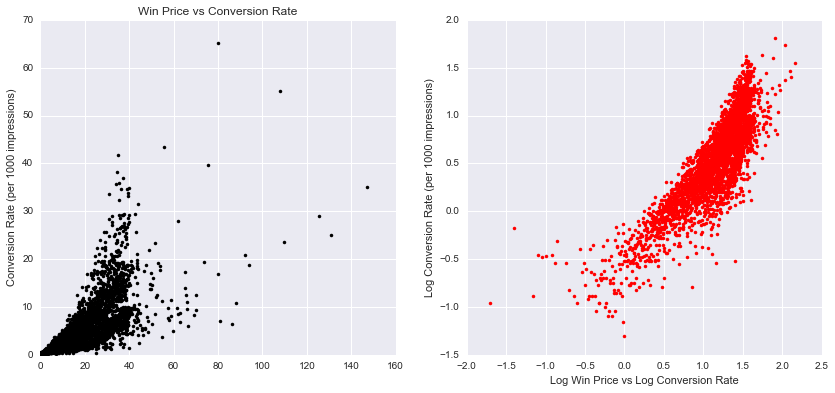

In [28]:

# x1 = np.linspace(0.0, 5.0)
# x2 = np.linspace(0.0, 2.0)

# y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
# y2 = np.cos(2 * np.pi * x2)
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(data1.win_price, data1.cr, 'k.')
plt.title('Win Price vs Conversion Rate')
plt.ylabel('Conversion Rate (per 1000 impressions)')

plt.subplot(1, 2, 2)
plt.plot(log_data1.win_price, log_data1.cr, 'r.')
plt.xlabel('Log Win Price vs Log Conversion Rate')
plt.ylabel('Log Conversion Rate (per 1000 impressions)')
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')


#plt.tight_layout()

plt.show()

In [30]:
from sklearn import feature_selection, linear_model

X = log_data1[['win_price']]
y = log_data1['cr']
lm = linear_model.LinearRegression().fit(X, y)

In [31]:
print lm.intercept_
print lm.coef_

-0.533193303844
[ 0.93468245]


P Values: [ 0.]
Coefficients: [ 0.93468245]
y-intercept: -0.533193303844
R-Squared: 0.727604511835


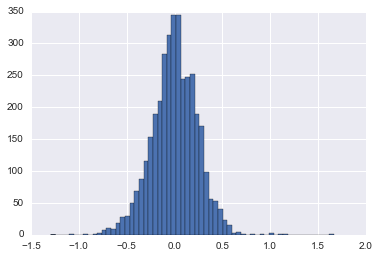

In [32]:
def get_linear_model_metrics(X, y, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X, y)[1]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    algo.fit(X,y)
    residuals = (y-algo.predict(X)).values

    # print the necessary values
    print 'P Values:', pvals
    print 'Coefficients:', algo.coef_
    print 'y-intercept:', algo.intercept_
    print 'R-Squared:', algo.score(X,y)
    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    # keep the model
    return algo

lm = get_linear_model_metrics(X, y, lm)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
P Values: [ 0.]
Coefficients: [ 0.]
y-intercept: 0.548885975888
R-Squared: 0.0



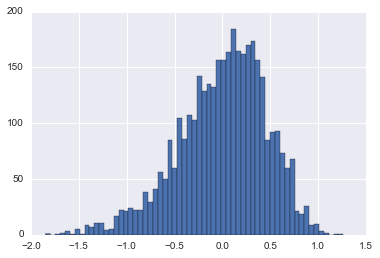

In [85]:
# loading other sklearn regression estimators
X = log_data1[['win_price']]
y = log_data1['cr']

estimators = [
    #linear_model.Lasso(),
    #linear_model.Ridge(),
    linear_model.ElasticNet(),
]

for est in estimators:
    print est
    get_linear_model_metrics(X, y, est)
    print

## Multivariable Linear Regression - Are win price & ad format predictive of conversion rate?

In [78]:
query2 = '''
select distinct ad_type,
round(win_bid_dollars,2) as win_price,
round(1000*sum(conversions)/nullif(sum(impressions),0)::float,2) as CR

from research_prod.bid_summary_4wk 
where fiksu_app_id != 0
and used_target = 'cost_per_download'

group by 1,2
having sum(impressions) > 100
and sum(conversions) > 0
order by 2 desc

'''
data2 = redshift_compute(query2)

In [79]:
data2.head()

,ad_type,win_price,cr
0,StandardAd,147.06,35.09
1,LiveRailVideoAd,131.00,24.88
2,LiveRailVideoAd,125.50,29.00
3,LiveRailVideoAd,109.81,23.55
4,LiveRailVideoAd,107.87,55.21


In [80]:
log_columns = ['win_price', 'cr']
log_data2 = data2.copy()
log_data2[log_columns] = log_data2[log_columns].apply(np.log10)

In [81]:
lm = linear_model.LinearRegression()
ad_type = pd.get_dummies(log_data2.ad_type)

In [82]:
log_data2[['Video','Native','Playable','Standard']] = pd.get_dummies(data2.ad_type)
del log_data2['ad_type']

P Values: [  0.00000000e+00   1.63268182e-01   1.34313792e-12   3.94287766e-01
   2.95489999e-01]
Coefficients: [  1.03649782e+00  -9.87339563e+10  -9.87339563e+10  -9.87339563e+10
  -9.87339563e+10]
y-intercept: 98733956319.3
R-Squared: 0.67753929837


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

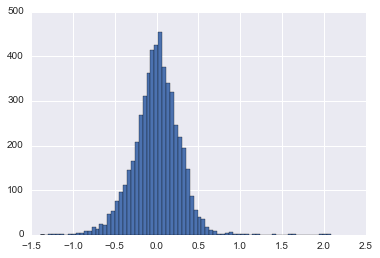

In [84]:
get_linear_model_metrics(log_data2[['win_price','Video','Native','Playable','Standard']],log_data2['cr'],lm)

### Including Ad Type as a categorical variable reduces the R squared value by 5 percent